# Milestone 3

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.QuoteBankData import QuoteBankData
from src.Deaths import Deaths
import src.utilities.quotebank_preprocessing_utils as utils
from src.CONSTS import CATEGORY_MAPPING, DATA_PATH, CATEGORIES, BEGIN_YEAR, END_YEAR, CATEGORY_MAPPING, COLOR_MAP, RENAME_CAT_COLS, RENAME_CAUSE_COLS, DROP_CAUSE_COLS
from src.utilities.synonym_utils import add_new_synonyms
from src.utilities.utils import *
from src.utilities.plotting import save_plt
import math

[nltk_data] Downloading package wordnet to C:\Users\Henrik Øberg
[nltk_data]     Myhre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Quotebank preprocessing

Most of the code used for the quotebank preprocessing can be found in the classes QuotebankData and Keyword, in addition to in files for helper functions. 

Initialize quotebank
- read keyword and synonyms for death causes
- create folders and file names for quotes that matches keywords or synonyms
- match keywords and synonyms with quotes

load database of speakers


In [2]:
quotebank = QuoteBankData("Asymmetry of News", [])
quotebank.read_keywords_from_file()
utils.create_directories_for_every_year()
quotebank.create_json_dumps_filenames_for_each_keyword()

In [3]:
import warnings
import collections

warnings.filterwarnings("ignore")

def save_meta_data_quotes():
    
    quotebank.quotes_occurrences_df = pd.DataFrame()
    for year in range(BEGIN_YEAR, END_YEAR + 1):
        dict_df_row = {"Year": year}
        
        for key in quotebank.keywords:
            file = key.output_filenames[year-BEGIN_YEAR]
            with open(file, 'rU') as f:
                quotes = pd.read_json(file, lines=True)
                
            dict_df_row[key.name] = 0
            if len(quotes) <= 0: continue
                
            # Save total number of quotes per year per topic in df
            num_of_quotes = quotes["n_appearances"].sum()
            dict_df_row[key.name] = num_of_quotes

            for _, line_quotes in quotes.iterrows():
                # Save number of quotes per topic per year per country of url
                country_urls = line_quotes['country_urls']
                for country in country_urls:
                    if country in key.country_url_occurences:
                        key.country_url_occurences[country] += 1
                    else:
                        key.country_url_occurences[country] = 1

                # Save number of quotes per topic per year per country of speaker
                country_speaker = line_quotes['country_speaker']
                if country_speaker:
                    if isinstance(country_speaker, list): # if multiple countries, take most occuring
                        country_speaker = collections.Counter(country_speaker).most_common(1)[0][0]

                    if country_speaker in key.country_speaker_occurences:
                        key.country_speaker_occurences[country_speaker] +=1
                    else:
                        key.country_speaker_occurences[country_speaker] = 1 
            
        quotebank.quotes_occurrences_df = quotebank.quotes_occurrences_df.append(dict_df_row, ignore_index = True)
        cols = quotebank.quotes_occurrences_df.columns
        quotebank.quotes_occurrences_df[cols] = quotebank.quotes_occurrences_df[cols].astype(int)

In [4]:
save_meta_data_quotes()

In [6]:
quotebank.quotes_percentage_df = percentage_of_total_count(quotebank.quotes_occurrences_df, quotebank.get_all_keyword_names())

In [7]:
quotebank.quotes_percentage_df

,Alzheimer disease and other dementias,Cardiovascular diseases,Chronic kidney disease,Chronic respiratory diseases,Cirrhosis and other chronic liver diseases,Diabetes mellitus,Diarrheal diseases,Digestive diseases,Drowning,Drug use and alcoholism,...,Neonatal disorders,Neoplasms,Nutritional deficiencies,Parkinson disease,Poisonings,Road injuries,Suicide,Tuberculosis,War and terrorism,Year
0,0.945691,4.678960,0.174816,1.115242,0.340154,0.282233,0.825637,0.101098,0.699264,0.843540,...,0.081089,10.067715,0.313826,0.310667,0.338048,5.739440,5.444570,0.199037,27.513506,2008
1,1.351575,3.776363,0.204985,1.034630,0.446186,0.257060,0.219897,0.168769,0.442872,0.702062,...,0.071484,10.776386,0.282150,0.386063,0.660165,5.733662,4.313442,0.160248,28.003409,2009
2,1.679153,3.848654,0.224713,1.084049,0.417625,0.283172,0.636961,0.079269,0.526358,1.242120,...,0.089792,11.193810,0.408272,0.313102,0.622931,5.070430,3.982640,0.138195,28.185738,2010
3,1.355847,3.649454,0.198065,1.121851,0.515901,0.214478,0.301644,0.086057,0.314065,0.614600,...,0.076964,10.786893,0.379495,0.538524,0.304306,4.380498,3.442960,0.155924,28.752922,2011
4,1.231040,2.488099,0.133421,0.710972,0.377874,0.167305,0.148094,0.087586,0.691155,0.372731,...,0.061870,7.989962,0.206636,0.315550,0.242184,5.012200,2.412312,0.105889,25.674100,2012
5,1.678708,3.604077,0.270257,1.126274,0.576759,0.282663,0.172712,0.173685,0.794960,0.626140,...,0.071031,11.848500,0.368776,0.548298,0.975699,4.968255,3.400958,0.153738,30.826096,2013
6,1.546086,3.255530,0.178226,1.027420,0.510279,0.219399,0.142962,0.190425,0.799443,0.659913,...,0.091496,9.863805,0.298695,0.591100,0.382757,4.433156,3.440428,0.183182,38.821993,2014
7,1.481696,2.744954,0.167041,1.013548,0.596022,0.193978,0.139330,0.117502,0.857653,0.659959,...,0.065021,10.377445,0.225405,0.363961,0.404366,3.999697,3.433088,0.117192,40.510319,2015
8,1.859901,3.159539,0.236340,0.883030,0.514850,0.280596,0.265071,0.118170,0.392046,0.918713,...,0.109828,9.440848,0.263218,0.388802,0.474997,3.913741,3.990203,0.092914,41.512158,2016


In [8]:
quotebank.map_df_causes_to_categories()

In [9]:
quotebank.cat_quotes_occurrences_df

,Year,Injuries,Non-communicable diseases,Communicable diseases
0,2008,69434.0,17108.0,8415.0
1,2009,312619.0,77743.0,32108.0
2,2010,312541.0,81783.0,33332.0
3,2011,336676.0,83261.0,30925.0
4,2012,541304.0,89256.0,30507.0
5,2013,302884.0,82667.0,25539.0
6,2014,400922.0,91190.0,32503.0
7,2015,501442.0,110174.0,34333.0
8,2016,334247.0,72860.0,24475.0


In [10]:
quotebank.cat_quotes_percentages_df = percentage_of_total_count(quotebank.cat_quotes_occurrences_df, CATEGORIES)

In [11]:
quotebank.cat_quotes_percentages_df

,Year,Injuries,Non-communicable diseases,Communicable diseases
0,2008,73.121518,18.016576,8.861906
1,2009,73.997917,18.402017,7.600066
2,2010,73.082337,19.123548,7.794115
3,2011,74.673847,18.467070,6.859083
4,2012,81.883379,13.501808,4.614812
5,2013,73.678270,20.109222,6.212508
6,2014,76.422138,17.382271,6.195591
7,2015,77.628729,17.056145,5.315125
8,2016,77.446928,16.882076,5.670996


# Our World in Data preprocessing

This part of the notebook is more exploratory. We wanted to preprocess and look at the two main datasets form Our World in Data to be sure that the project is possible to do. 

## Preprocess death data

### Deaths by cause

In [12]:
death_by_cause_path = DATA_PATH + "annual_number_of_deaths_by_cause.csv"
deaths_by_cause = Deaths("deaths_by_cause", "World", death_by_cause_path, rename_cols = RENAME_CAUSE_COLS, drop_cols = DROP_CAUSE_COLS)
deaths_by_cause.df

,Entity,Code,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic kidney disease,Chronic respiratory diseases,...,Maternal disorders,Neonatal disorders,Diarrheal diseases,Suicide,Diabetes mellitus,Poisonings,War and terrorism,Exposure to forces of nature,Nutritional deficiencies,Drug use and alcoholism
0,World,OWID_WRL,2008,348040.083847,2.657275e+06,176583.045171,1.500828e+07,1.790400e+06,9.528553e+05,3.419369e+06,...,249888.643281,2.304429e+06,1.867836e+06,789447.007136,1.045381e+06,78008.099106,67952.082371,295881.442960,650025.252823,287619.724142
1,World,OWID_WRL,2009,340514.177436,2.639562e+06,173745.686452,1.527431e+07,1.863444e+06,9.866682e+05,3.469693e+06,...,246340.811729,2.258315e+06,1.865671e+06,791222.757559,1.070186e+06,77339.491051,77189.308722,68277.808308,635954.543146,285320.956384
2,World,OWID_WRL,2010,331205.914662,2.623649e+06,170071.404053,1.561962e+07,1.943961e+06,1.019565e+06,3.522114e+06,...,242374.367555,2.211208e+06,1.857640e+06,796083.645174,1.096402e+06,77298.902918,58435.273695,363837.299083,641791.080428,288506.378358
3,World,OWID_WRL,2011,325000.383494,2.616651e+06,168716.792532,1.585974e+07,2.025064e+06,1.052780e+06,3.550905e+06,...,234088.413573,2.162070e+06,1.793641e+06,793977.906088,1.129959e+06,76227.682073,108814.611560,89366.680283,618725.210271,288507.494650
4,World,OWID_WRL,2012,316965.020009,2.605154e+06,166735.397312,1.611549e+07,2.098871e+06,1.082857e+06,3.555093e+06,...,221423.708544,2.110626e+06,1.725018e+06,786335.554940,1.168569e+06,75414.520357,126929.890101,64283.962330,579225.038064,292033.120011
5,World,OWID_WRL,2013,312013.523643,2.590482e+06,164572.376351,1.628402e+07,2.168918e+06,1.112929e+06,3.570845e+06,...,212655.973665,2.050610e+06,1.664193e+06,779212.549795,1.202743e+06,74906.641101,137411.255671,74874.464645,557568.566594,300325.129358
6,World,OWID_WRL,2014,306484.322622,2.579538e+06,162420.462719,1.662836e+07,2.253866e+06,1.147229e+06,3.638294e+06,...,206311.290374,1.989193e+06,1.619718e+06,781716.697241,1.249135e+06,74439.682294,226729.944451,61575.894639,539496.675896,311573.610921
7,World,OWID_WRL,2015,298711.517721,2.582199e+06,159257.591692,1.713999e+07,2.353634e+06,1.185372e+06,3.739118e+06,...,199530.977239,1.925458e+06,1.578439e+06,782941.162890,1.299556e+06,74394.517062,176482.287532,72488.354651,526248.610811,325986.603083
8,World,OWID_WRL,2016,295878.990018,2.574625e+06,155448.606112,1.752437e+07,2.440042e+06,1.216963e+06,3.826620e+06,...,196170.819390,1.852924e+06,1.550848e+06,788674.564776,1.346428e+06,73643.079320,193227.402289,61444.305454,511310.637890,341369.595111


In [13]:
deaths_by_cause.percentage_df

,Entity,Code,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic kidney disease,Chronic respiratory diseases,...,Maternal disorders,Neonatal disorders,Diarrheal diseases,Suicide,Diabetes mellitus,Poisonings,War and terrorism,Exposure to forces of nature,Nutritional deficiencies,Drug use and alcoholism
0,World,OWID_WRL,2008,0.700192,5.345947,0.355253,30.193900,3.601955,1.916969,6.879140,...,0.502730,4.636086,3.757741,1.588222,2.103115,0.156938,0.136707,0.595259,1.307731,0.578638
1,World,OWID_WRL,2009,0.682428,5.289976,0.348206,30.611429,3.734549,1.977393,6.953651,...,0.493694,4.525914,3.739013,1.585699,2.144772,0.154997,0.154696,0.136836,1.274524,0.571815
2,World,OWID_WRL,2010,0.653592,5.177430,0.335614,30.823280,3.836153,2.011978,6.950433,...,0.478294,4.363531,3.665810,1.570967,2.163606,0.152539,0.115314,0.717985,1.266491,0.569330
3,World,OWID_WRL,2011,0.640791,5.159152,0.332653,31.270041,3.992743,2.075727,7.001185,...,0.461543,4.262872,3.536454,1.565456,2.227897,0.150295,0.214546,0.176201,1.219917,0.568839
4,World,OWID_WRL,2012,0.622269,5.114465,0.327337,31.638096,4.120525,2.125876,6.979395,...,0.434701,4.143603,3.386573,1.543742,2.294146,0.148055,0.249190,0.126203,1.137141,0.573322
5,World,OWID_WRL,2013,0.610462,5.068342,0.321990,31.860088,4.243542,2.177473,6.986446,...,0.416067,4.012069,3.256034,1.524548,2.353196,0.146557,0.268848,0.146494,1.090897,0.587593
6,World,OWID_WRL,2014,0.591830,4.981157,0.313638,32.109811,4.352276,2.215331,7.025643,...,0.398393,3.841186,3.127720,1.509516,2.412113,0.143745,0.437822,0.118905,1.041783,0.601657
7,World,OWID_WRL,2015,0.567101,4.902279,0.302349,32.540099,4.468350,2.250416,7.098677,...,0.378808,3.655462,2.996650,1.486406,2.467194,0.141237,0.335050,0.137618,0.999078,0.618882
8,World,OWID_WRL,2016,0.554221,4.822619,0.291176,32.825503,4.570527,2.279535,7.167775,...,0.367454,3.470776,2.904948,1.477294,2.522040,0.137943,0.361941,0.115093,0.957754,0.639431


### Deaths by category

In [14]:
death_by_category_path = DATA_PATH + "categorized_annual_number_of_deaths.csv"
deaths_by_category = Deaths("deaths_by_category",'World', death_by_category_path, rename_cols = RENAME_CAT_COLS)
deaths_by_category.df

,Entity,Code,Year,Non-communicable diseases,Communicable diseases,Injuries
0,World,OWID_WRL,2008,3.418150e+07,1.308734e+07,4.634715e+06
1,World,OWID_WRL,2009,3.483548e+07,1.281121e+07,4.425399e+06
2,World,OWID_WRL,2010,3.559222e+07,1.252802e+07,4.718076e+06
3,World,OWID_WRL,2011,3.621622e+07,1.219007e+07,4.487698e+06
4,World,OWID_WRL,2012,3.683037e+07,1.180971e+07,4.462361e+06
5,World,OWID_WRL,2013,3.735997e+07,1.146154e+07,4.452354e+06
6,World,OWID_WRL,2014,3.825766e+07,1.117078e+07,4.507679e+06
7,World,OWID_WRL,2015,3.945300e+07,1.088245e+07,4.486745e+06
8,World,OWID_WRL,2016,4.040355e+07,1.060071e+07,4.505297e+06


In [15]:
deaths_by_category.percentage_df

,Entity,Code,Year,Non-communicable diseases,Communicable diseases,Injuries
0,World,OWID_WRL,2008,65.855794,25.214733,8.929473
1,World,OWID_WRL,2009,66.898568,24.602832,8.498600
2,World,OWID_WRL,2010,67.360623,23.710107,8.929270
3,World,OWID_WRL,2011,68.469444,23.046231,8.484325
4,World,OWID_WRL,2012,69.357208,22.239485,8.403306
5,World,OWID_WRL,2013,70.128132,21.514385,8.357483
6,World,OWID_WRL,2014,70.931427,20.711133,8.357440
7,World,OWID_WRL,2015,71.965378,19.850444,8.184177
8,World,OWID_WRL,2016,72.786653,19.097091,8.116256


## Plotting

### Deaths by cause

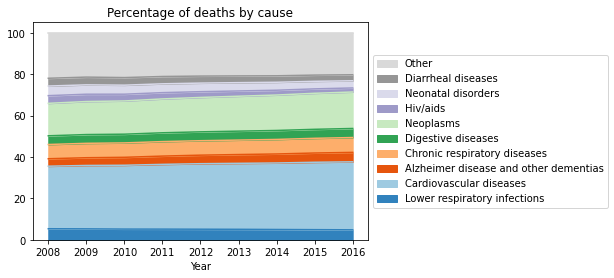

In [16]:
deaths_by_cause.plot_stacked_areas("", "Percentage of deaths by cause")

In [17]:
def pie_chart_plot(df, year, threshold):
    
    pc_df = df.iloc[: , 3:]
    pc_df = pc_df.iloc[[year - 2008]]
    
    other = 0
    sorted_pd = pd.DataFrame(np.sort(pc_df.values))
    
    for column in pc_df:
        if ((pc_df[column].values)) < sorted_pd.iloc[: ,-threshold].values:
            other += pc_df[column].values
            pc_df.drop([column], axis=1, inplace=True)
            
    pc_df = pc_df.assign(Other=other)
    title = "Deaths in " + str(year)
    pc_df.T.plot.pie(colormap=COLOR_MAP, subplots=True, figsize=(20, 6), legend=None, ylabel = '', startangle=270, autopct='%1.1f%%', pctdistance=0.7)
    save_plt(title)

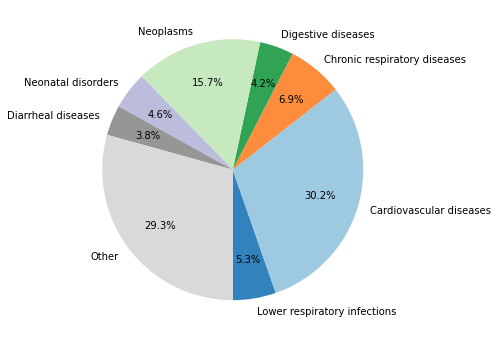

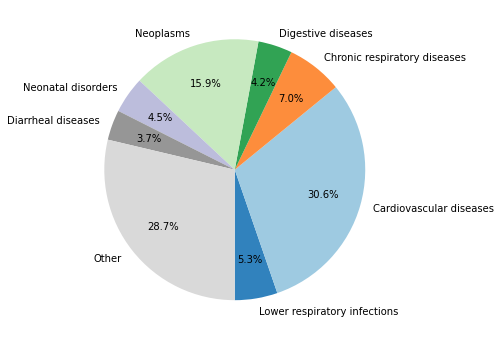

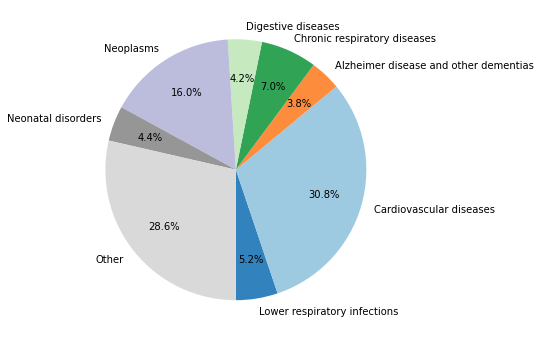

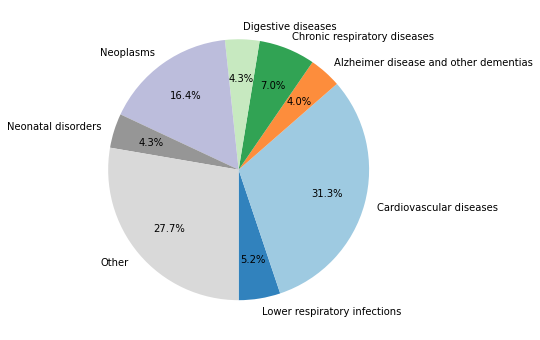

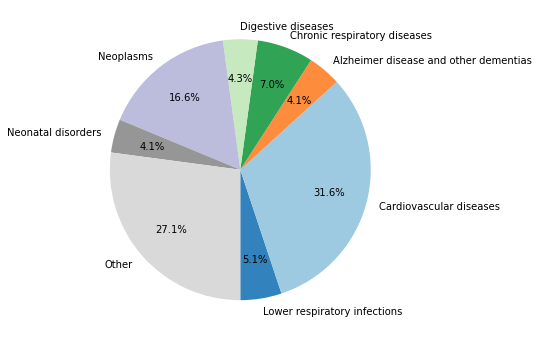

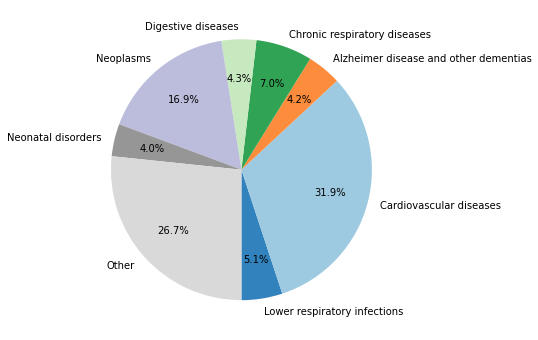

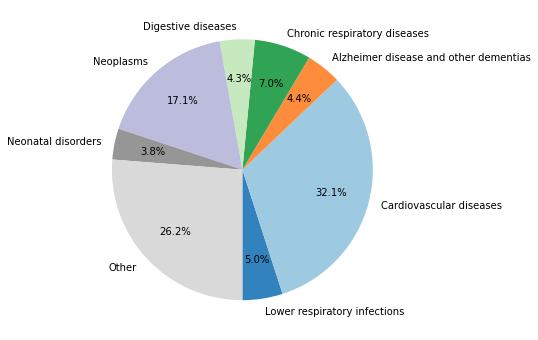

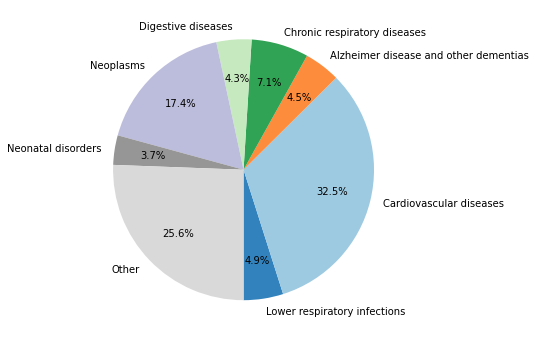

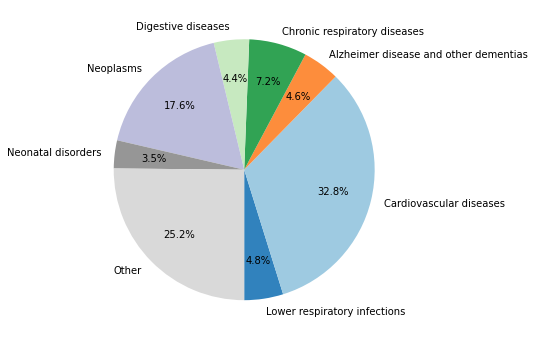

In [19]:
for y in range(BEGIN_YEAR, END_YEAR + 1):
    pie_chart_plot(deaths_by_cause.percentage_df, y, 7)

### Deaths by category

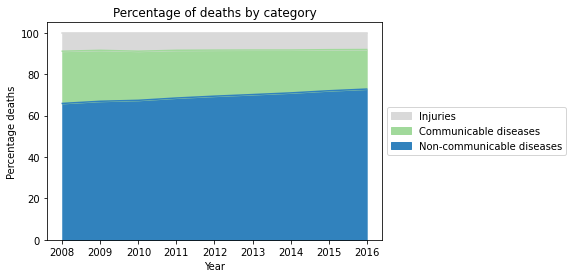

In [20]:
deaths_by_category.plot_stacked_areas("Percentage deaths", "Percentage of deaths by category")

# RQ1

In [23]:
def get_summed_values(df, cols):
    values = []
    for col in cols:
        values.append(df[col].sum())
    return np.array(values)


def create_RQ1_df():
    causes = deaths_by_cause.quant_columns
    
    summed_death_values = get_summed_values(deaths_by_cause.df, causes)
    summed_quote_values = get_summed_values(quotebank.quotes_occurrences_df, causes)
    
    quotes_per_death = np.divide(summed_quote_values, summed_death_values/1000000)
    
    df = pd.DataFrame(columns=causes)

    for i, cause in enumerate(causes):
        df.at[0, cause] = quotes_per_death[i]
    
    return df


def plot_RQ1(log = True):
    
    df = create_RQ1_df()

    df = df.T
    value_col = list(df.columns)[0]
    df = df.sort_values([value_col], ascending=False)
    
    ax = plt.gca()
    df.plot.barh(figsize=(12,12), log=log, title=None, ax=ax, xlabel=None, ylabel=None, color="#006198", legend=None, xlim = (10**2,10**6))
    
    # Remove border top and right
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    
    # Remove y Ticks
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.6,
            alpha = 0.2)
        
    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.4,
                 ' ' + pretty_num_string(int(i.get_width())),
                 fontsize = 10, fontweight ='bold',
                 color ="#777777")
        
    save_plt("quotes_per_million_deaths")
    plt.show()    

NameError: name 'pretty_num_string' is not defined

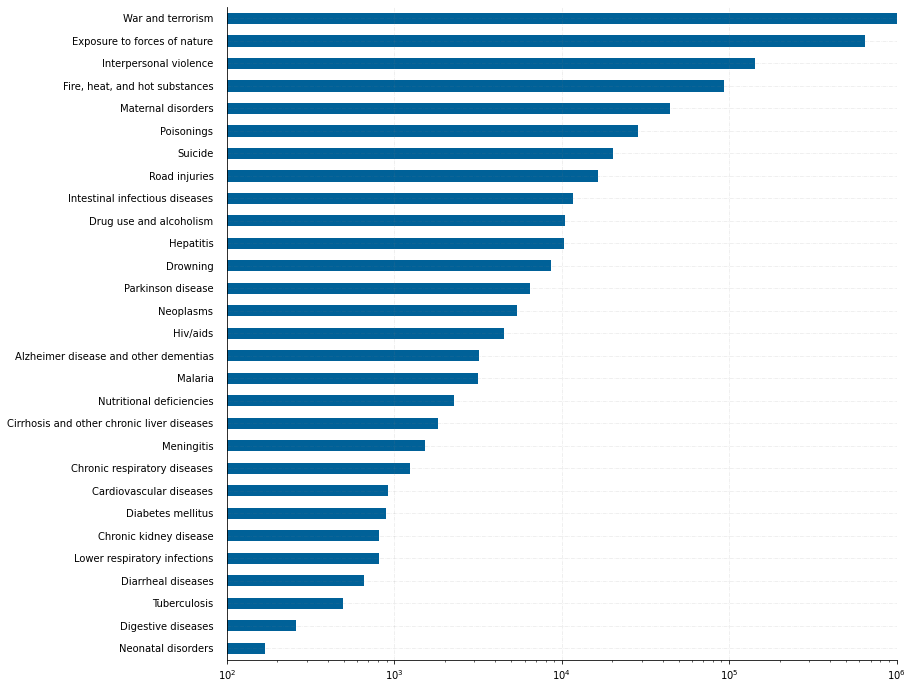

In [24]:
plot_RQ1()

In [ ]:
quotebank.quotes_percentage_df.columns

# RQ5

In [ ]:
def group_quotebank_cols():
    print(":)")

In [ ]:
def plot_RQ5():
    bar_labels = ["quotes", "deaths"]
    width = 0.35
    
    prev_values = [0, 0]

    fig, ax = plt.subplots()

    for column in deaths_by_category.quant_columns:
        values = [quotebank.cat_quotes_percentage_df[column].sum().item(), 
                  deaths_by_category.percentage_df[column].sum().item()]

        ax.bar(bar_labels, values, width, bottom = prev_values, label=column)
        prev_values[0] += values[0]
        prev_values[1] += values[1]

    ax.set_ylabel('')
    ax.legend()

    plt.show()

In [ ]:
plot_RQ5()